Quanvolutional Neural Networks
==============================


###**Introduction**


---






## Classical convolution

Convolutional Neural Networks (CNNs) are a foundational model in classical machine learning, particularly well-suited for processing images. The key concept behind CNNs is the convolutional layer, where, rather than applying a global function to the entire input data, a local convolution is performed.


*   For an image input, the model examines small sections of the image one at a time, applying the same kernel to each section.

* The results obtained for each region are usually associated to different channels of a single output pixel.

*   The union of all the output pixels creates a new image-like object, which can then be further processed by additional layers in the network.
## Quantum convolution


Quantum convolution is based on the same principles as classical convolution, but it leverages quantum computing.

***Procedure***

1.  A small region of the input image is embedded into a quantum circuit.
2.  The qubits, initialized in the ground state, undergo parameterized rotations. This step encodes the input data into the quantum system.
3.  A unitary operation U is performed on the system.
The unitary can be generated by a variational quantum circuit or, more simply, by a random circuit.
4. The quantum system is measured, producing a list of classical expectation values.
The measurement results can also be classically post-processed if needed.
.
5.  Similar to classical convolution, each expectation value is mapped to a different channel of a single output pixel.
6.By repeating this procedure over different regions, the entire input image is scanned, producing an output object structured as a multi-channel image.


6.  The quantum convolution can be followed by further quantum layers or by classical layers


*In this tutorial, we use a fixed quantum circuit as a "quanvolution" layer, similar to the method of the paper [ Henderson et al. (2019).](https://arxiv.org/abs/1904.04767). While the classical layers that follow are trained for classification, it's possible to train the quantum circuit itself using PennyLane's gradient features.*

###**General setup**
-------------

**Installation and Imports**:

We will first Install and import PennyLane with the *TensorFlow* interface and the plotting library *matplotlib*.

In [15]:
!pip install pennylane

In [16]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Setting hyper-parameters
=================================================
We sets the hyper-parameters for training and data processing

In [17]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Loading of the MNIST dataset
============================

We loads and preprocesses the MNIST dataset. We use a small number of training and test image for speedup evolution.

In [10]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Quantum circuit as a convolution kernel
=======================================

 We begin by initializing a default.qubit device to simulate a quantum system with 4 qubits. This device is then used to create a quantum node, or qnode, which represents the quantum circuit

1.  The circuit starts with an embedding layer where we apply local rotations Ry to each qubit scalled by $\pi$.


2.  Next, we introduce a random circuit consisting of a variable number of layers, denoted as n_layers.


3.   Measuring the quantum state of each qubit to estimate 4 different expectation values.

In [11]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function implements the following convolution scheme:

1.  the image is split into $2 \times 2$ pixels squares;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.

This reduces the image resolution by half, equivalent to applying a
 $2 \times 2$ convolutional kernel with a stride of 2 in standard CNN terminology.


In [12]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Quantum pre-processing of the dataset
=====================================
 We utilize the quantum convolution layer as a pre-processing step for all images in our dataset. By doing so, we avoid repeatedly performing quantum computations during the training of the classical model. Instead, the classical model is trained and tested on this pre-processed dataset.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.



In [22]:
import os
os.makedirs(SAVE_PATH, exist_ok=True)

In [23]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


# Visualizing Quantum Convolution Effects


*   Each image batch undergoes quantum convolution.


*   The resulting 4 output channels are displayed in grayscale beneath each input image.



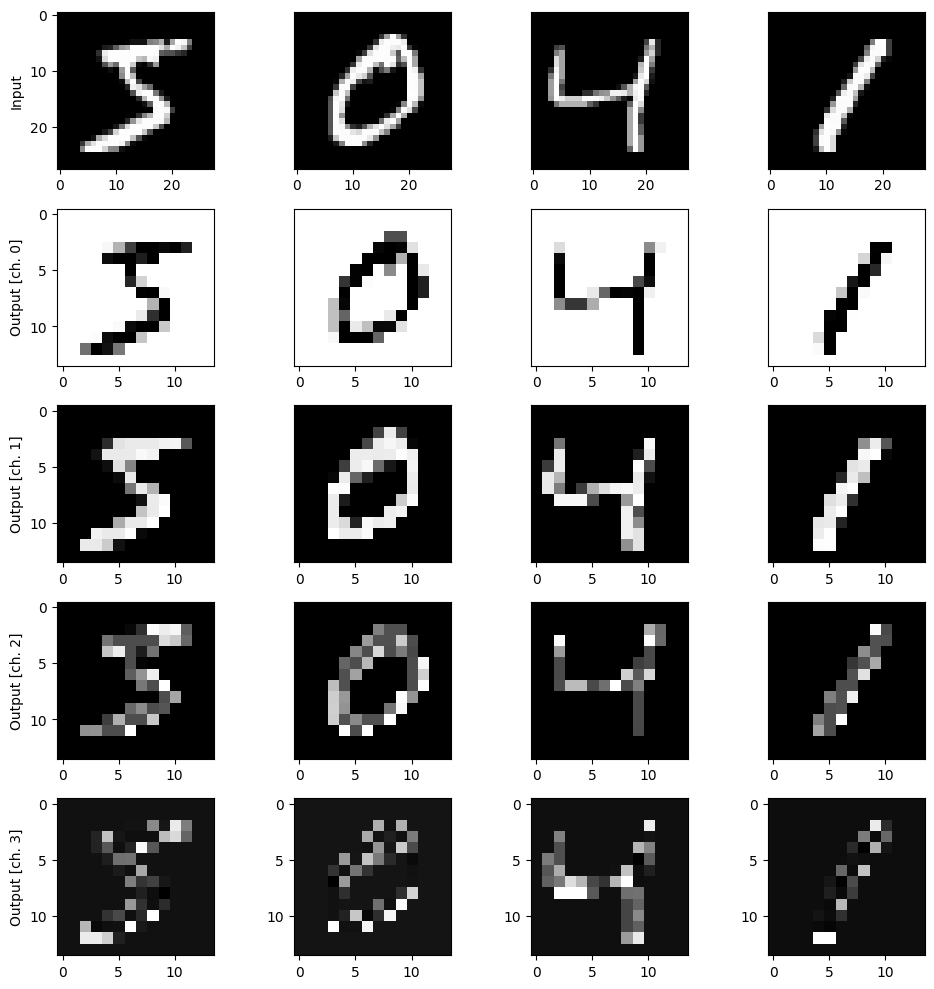

In [25]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Hybrid quantum-classical model
==============================

Once the quantum convolution layer has processed the images, we pass the extracted features into a classical neural network designed to classify the 10 digits of the MNIST dataset.

Our approach utilizes a straightforward architecture: a fully connected neural network with a single layer that includes 10 output nodes, followed by a softmax activation function to produce the final classification probabilities.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


In [26]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========
We first set up the model and train it with the dataset pre-processed by quantum convolution. This allows us to leverage the quantum features for classification.


In [27]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 102ms/step - accuracy: 0.0600 - loss: 2.9343 - val_accuracy: 0.1667 - val_loss: 2.3388
Epoch 2/30
13/13 - 0s - 12ms/step - accuracy: 0.2200 - loss: 2.1889 - val_accuracy: 0.2333 - val_loss: 2.1454
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.4000 - loss: 1.8472 - val_accuracy: 0.3000 - val_loss: 2.0242
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.5800 - loss: 1.5150 - val_accuracy: 0.4333 - val_loss: 1.8720
Epoch 5/30
13/13 - 0s - 11ms/step - accuracy: 0.7400 - loss: 1.2622 - val_accuracy: 0.4667 - val_loss: 1.7388
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.8400 - loss: 1.0545 - val_accuracy: 0.4667 - val_loss: 1.6431
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 0.8846 - val_accuracy: 0.5333 - val_loss: 1.5659
Epoch 8/30
13/13 - 0s - 11ms/step - accuracy: 0.9400 - loss: 0.7498 - val_accuracy: 0.5333 - val_loss: 1.4956
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.6397 - val_accuracy: 0.5667 - val_loss: 1.4366
Epoch 10/30

# Comparison with Classical Model
We also train a classical version of the model directly on raw MNIST images to compare performance between the quantum-processed and non-processed datasets.


In [28]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 132ms/step - accuracy: 0.2000 - loss: 2.2679 - val_accuracy: 0.2667 - val_loss: 2.1632
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.4400 - loss: 1.8844 - val_accuracy: 0.4000 - val_loss: 1.9999
Epoch 3/30
13/13 - 0s - 11ms/step - accuracy: 0.6200 - loss: 1.6124 - val_accuracy: 0.5000 - val_loss: 1.8615
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.8200 - loss: 1.3864 - val_accuracy: 0.5333 - val_loss: 1.7427
Epoch 5/30
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 1.1970 - val_accuracy: 0.5667 - val_loss: 1.6407
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9000 - loss: 1.0389 - val_accuracy: 0.5667 - val_loss: 1.5537
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9200 - loss: 0.9072 - val_accuracy: 0.6333 - val_loss: 1.4799
Epoch 8/30
13/13 - 0s - 11ms/step - accuracy: 0.9200 - loss: 0.7973 - val_accuracy: 0.6333 - val_loss: 1.4172
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.7051 - val_accuracy: 0.6333 - val_loss: 1.3635
Epoch 10/30

Results
=======

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


<ipython-input-29-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


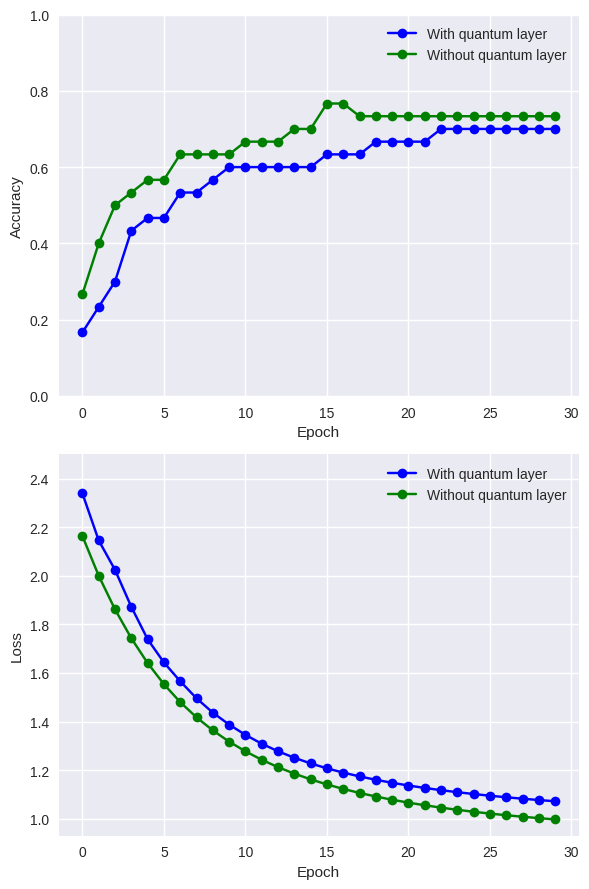

In [29]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()